In [1]:
import os
import hydra
import logging
import json
import pandas as pd
import joblib
import warnings
import rootutils
import numpy as np
from pathlib import Path
from hydra.core.hydra_config import HydraConfig
import omegaconf

rootutils.setup_root(search_from="../", indicator=".project-root", pythonpath=True)

from src.experiment.utils import (
    assign_fold_index,
    plot_confusion_matrix,
    visualize_feature_importance,
    plot_label_distributions,
    plot_venn_diagrams,
)
from src.experiment.feature.runner import run_extractors
from src.experiment.model.runner import train_cv_tabular_v1, predict_cv_tabular_v1
from src.utils.log_utils import get_consol_handler, get_file_handler
from src.experiment.optimization import opt_macro_f1_score_v2, decode_v2

/var/folders/f6/w15wz9z96kdghdywjdc6gt140000gn/T/ipykernel_96524/1739471464.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
OVERRIDES: list[str] = os.getenv("OVERRIDES", "experiment=002-v02").split(",")

### Env


In [3]:
if OVERRIDES is None:
    raise ValueError("OVERRIDES is not set")

with hydra.initialize(version_base=None, config_path="../configs"):
    CFG = hydra.compose(
        config_name="config.yaml",
        return_hydra_config=True,
        overrides=OVERRIDES,
    )
    HydraConfig.instance().set_config(
        CFG
    )  # use HydraConfig for notebook to use hydra job

# set directories as global variables
INPUT_DIR = Path(CFG.paths.input_dir)

if CFG.debug:
    CFG.paths.output_dir = f"{CFG.paths.output_dir}_debug"

OUTPUT_DIR = Path(CFG.paths.output_dir)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
BASE_OUTPUT_DIR = Path(CFG.paths.resource_dir) / "outputs"


# set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [
    get_file_handler(OUTPUT_DIR / "notebook.log"),
    get_consol_handler(),
]

warnings.filterwarnings("ignore")

### Load Data


In [4]:
def assign_meta(df: pd.DataFrame, data="train", group_cols=["State", "FranchiseCode"]):
    logger.info(f"group_cols: {group_cols}")
    df["data"] = data
    df["fold"] = -1

    if group_cols == "no_use" or group_cols is None:
        df["group"] = list(range(len(df)))
        return df

    if group_cols is not None:
        df["group"] = pd.concat(
            [df[col].astype(str) for col in group_cols], axis=1
        ).apply("_".join, axis=1)
        return df


def money_to_numeric(x: str) -> int:
    return int(x.replace("$", "").replace(",", "").split(".")[0])


def transform_money(input_df: pd.DataFrame):
    df = input_df.copy()
    df["DisbursementGross"] = df["DisbursementGross"].map(
        money_to_numeric, na_action="ignore"
    )
    df["GrAppv"] = df["GrAppv"].map(money_to_numeric, na_action="ignore")
    df["SBA_Appv"] = df["SBA_Appv"].map(money_to_numeric, na_action="ignore")
    return df


train_df = pd.read_csv(INPUT_DIR / "train.csv").rename(columns={"Unnamed: 0": "uid"})
test_df = (
    pd.read_csv(INPUT_DIR / "test.csv")
    .rename(columns={"Unnamed: 0": "uid"})
    .assign(MIS_Status=np.nan)
)
sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

train_df = assign_meta(
    train_df,
    data="train",
    group_cols=CFG.get("group_cols") or ["State", "FranchiseCode"],
)
test_df = assign_meta(test_df, data="test")

train_df = transform_money(train_df)
test_df = transform_money(test_df)

2024-02-10 18:06:19,571 - root - INFO : group_cols: ['State', 'FranchiseCode']
2024-02-10 18:06:19,633 - root - INFO : group_cols: ['State', 'FranchiseCode']


### CV Split


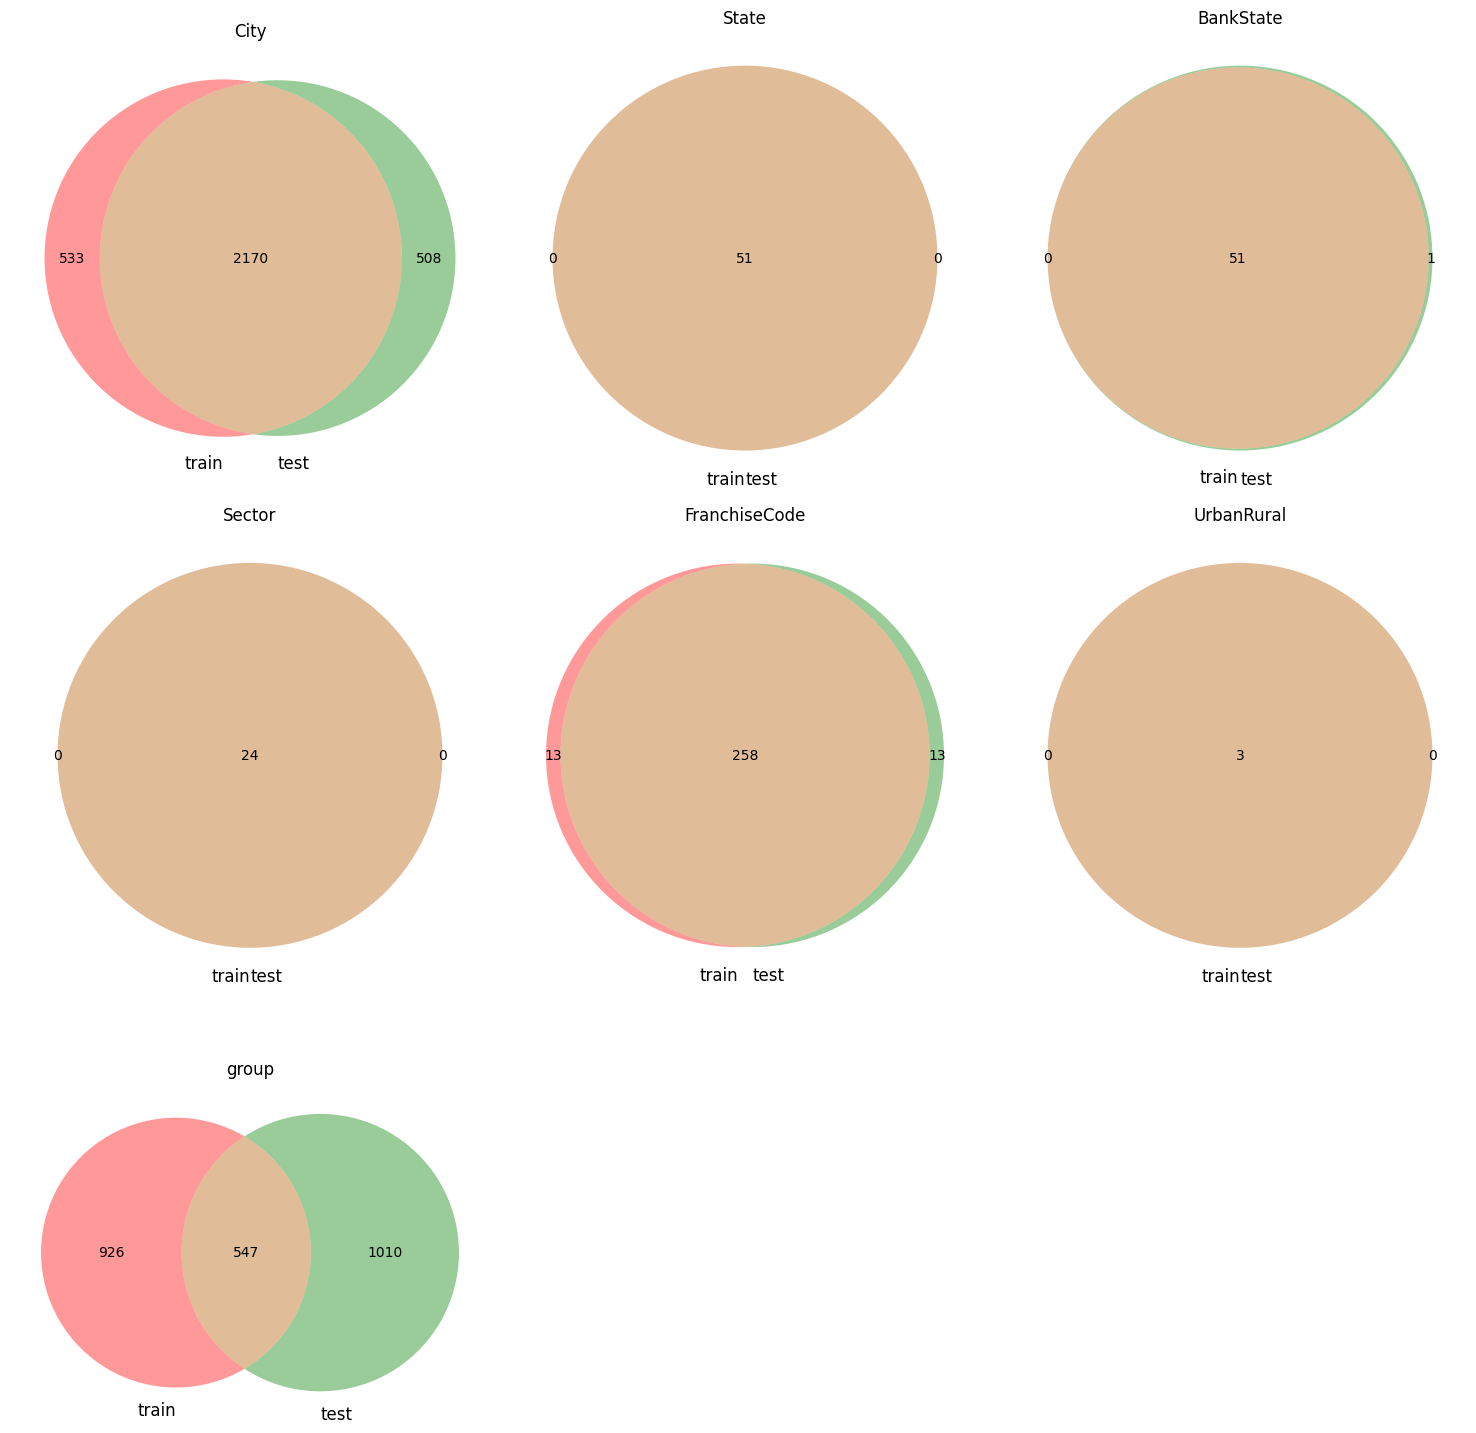

In [5]:
# check label distribution
plot_venn_diagrams(
    train_df,
    test_df,
    cat_cols=[
        "City",
        "State",
        "BankState",
        "Sector",
        "FranchiseCode",
        "UrbanRural",
        "group",
    ],
)

In [6]:
kfold = hydra.utils.instantiate(CFG.cv)
train_df = assign_fold_index(
    train_df=train_df, kfold=kfold, y_col="MIS_Status", group_col="group"
)

if CFG.debug:
    train_df_neg = train_df.query("MIS_Status == 0").sample(1000, random_state=CFG.seed)
    train_df_pos = train_df.query("MIS_Status == 1").sample(1000, random_state=CFG.seed)
    train_df = pd.concat([train_df_neg, train_df_pos]).reset_index(drop=True)

train_df.groupby("fold")["MIS_Status"].agg(["count", "mean", "sum"]).assign(
    negative=lambda x: x["count"] - x["sum"], ratio=lambda x: x["sum"] / x["count"]
)

,count,mean,sum,negative,ratio
fold,,,,,
0,5218,0.870257,4541,677,0.870257
1,12018,0.894408,10749,1269,0.894408
2,9406,0.903679,8500,906,0.903679
3,5389,0.898126,4840,549,0.898126
4,10276,0.889159,9137,1139,0.889159


### Assign Ensemble


In [7]:
ensemble_exps = CFG.get("ensemble_exps")
pred_cols = CFG.get("ensemble_pred_cols") or ["pred"]

if ensemble_exps is not None:
    for exp in ensemble_exps:
        logger.info(f"Load {exp} ...")
        train_filepath = BASE_OUTPUT_DIR / exp / "valid_result_df.pkl"
        test_filepath = BASE_OUTPUT_DIR / exp / "test_result_df.pkl"

        train_result_df = (
            joblib.load(train_filepath)[["uid", "pred", "pred_label"]]
            .assign(
                pred=lambda x: np.array(x["pred"].tolist()).reshape(-1)
            )  # reshape to 1d array
            .set_index("uid")[pred_cols]
            .add_prefix(f"f_{exp}_")
        )
        test_result_df = (
            joblib.load(test_filepath)[["uid", "pred", "pred_label"]]
            .assign(
                pred=lambda x: np.array(x["pred"].tolist()).reshape(-1)
            )  # reshape to 1d array
            .set_index("uid")[pred_cols]
            .add_prefix(f"f_{exp}_")
        )
        train_df = train_df.merge(train_result_df, on="uid", how="left")
        test_df = test_df.merge(test_result_df, on="uid", how="left")

### Feature Engineering


In [8]:
def get_agg_feature_extractors(feature_extractors, all_group_keys):
    if feature_extractors is None:
        return []

    if all_group_keys is None:
        return []

    extractors = []
    for extractor in feature_extractors:
        for group_keys in all_group_keys:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            extractors.append(_extractor)
    return extractors


# train features : train data のみから作成
feature_extractors = hydra.utils.instantiate(CFG.feature_extractors)
feature_extractors.extend(
    get_agg_feature_extractors(
        feature_extractors=CFG.get("agg_feature_extractors"),
        all_group_keys=CFG.get("group_keys_for_agg"),
    )
)
feature_extractors.extend(
    get_agg_feature_extractors(
        feature_extractors=CFG.get("te_feature_extractors"),
        all_group_keys=CFG.get("group_keys_for_te"),
    )
)
feature_extractors.extend(
    get_agg_feature_extractors(
        feature_extractors=CFG.get("rolling_agg_feature_extractors"),
        all_group_keys=CFG.get("group_keys_for_rolling_agg"),
    )
)

train_feature_df = run_extractors(
    input_df=train_df,
    extractors=feature_extractors,
    dirpath=Path(CFG.paths.feature_store_dir),
    fit=True,
    cache=CFG.cache_feature_extractors,
)
train_feature_df = pd.concat([train_df, train_feature_df], axis=1)

# test features : test data から作成
feature_extractors = hydra.utils.instantiate(CFG.feature_extractors)
feature_extractors.extend(
    get_agg_feature_extractors(
        feature_extractors=CFG.get("agg_feature_extractors"),
        all_group_keys=CFG.get("group_keys_for_agg"),
    )
)
feature_extractors.extend(
    get_agg_feature_extractors(
        feature_extractors=CFG.get("te_feature_extractors"),
        all_group_keys=CFG.get("group_keys_for_te"),
    )
)
feature_extractors.extend(
    get_agg_feature_extractors(
        feature_extractors=CFG.get("rolling_agg_feature_extractors"),
        all_group_keys=CFG.get("group_keys_for_rolling_agg"),
    )
)
test_feature_df = run_extractors(
    input_df=test_df,
    extractors=feature_extractors,
    dirpath=Path(CFG.paths.feature_store_dir),
    fit=False,
    cache=CFG.cache_feature_extractors,
)

test_feature_df = pd.concat([test_df, test_feature_df], axis=1)

feature_columns = [col for col in train_feature_df.columns if col.startswith("f_")]

train_feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)

logger.info(f"train_feature_df.shape: {train_feature_df.shape}")
logger.info(f"test_feature_df.shape: {test_feature_df.shape}")

2024-02-10 18:06:20,486 - src.experiment.feature.runner - INFO : <DisbursementDateExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
2024-02-10 18:06:20,582 - src.experiment.feature.runner - INFO : <ApprovalDateExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
2024-02-10 18:06:21,185 - src.experiment.feature.runner - INFO : <DisbursementGrossExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
2024-02-10 18:06:21,187 - src.experiment.feature.runner - INFO : <GrAppvExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
2024-02-10 18:06:21,189 - src.experiment.feature.runner - INFO : <SBA_AppvExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
2024-02-10 18:06:21,190 - src.experiment.feature.runner - INFO : <RevLineCrExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
2024-02-10 18:06:21,199 - src.experiment.feature.runner - INFO : <Lo

### Training


In [9]:
def assign_seed_average_pred(result_df: pd.DataFrame) -> pd.DataFrame:
    cols = [col for col in result_df.columns if col.startswith("pred_")]
    pred = 0
    for col in cols:
        pred += np.array(result_df[col].tolist())
    result_df["pred"] = list(pred / len(cols))
    return result_df.reset_index()


def to_python_type(value):
    if isinstance(value, omegaconf.DictConfig):
        return dict(value)
    elif isinstance(value, omegaconf.ListConfig):
        return list(value)
    else:
        return value


valid_result_df = pd.DataFrame()
all_trained_estimators = []
scores = {}
for seed in CFG.seed_average_seeds:
    logger.info(f"\n\nstart training seed={seed} 🚀")

    fit_params = dict(hydra.utils.instantiate(CFG.model.fit_params))
    params = {k: to_python_type(v) for k, v in CFG.model.get("params").items()}
    if CFG.model.estimator._target_.startswith("lightgbm.LGBM"):
        params["random_state"] = seed
        params["num_leaves"] = seed  # lgbm

        eval_metrics = CFG.model.get("eval_metrics")
        if eval_metrics is not None:
            eval_metrics = [hydra.utils.get_object(x) for x in eval_metrics]
            fit_params["eval_metric"] = eval_metrics

        logger.info(f"eval_metrics: {eval_metrics}")
        # NOTE : class_weight などが omegaconf.DictConfig の場合 error になるため set_params で設定

    if CFG.model.estimator._target_.startswith("xgboost.XGB"):
        params["max_depth"] = seed

        eval_metric = CFG.model.get("eval_metrics")
        if eval_metric is not None:
            eval_metric = hydra.utils.get_object(eval_metric)
            params["eval_metric"] = eval_metric

    estimator = hydra.utils.instantiate(CFG.model.estimator).set_params(**params)

    model_output_dir = OUTPUT_DIR / "models" / f"seed{seed}"
    trained_estimators = train_cv_tabular_v1(
        df=train_feature_df,
        estimator=estimator,
        feature_columns=feature_columns,
        target_columns=["MIS_Status"],
        fit_params=fit_params,
        output_dir=model_output_dir,
        overwrite=CFG.overwrite_training,
        use_xgb_class_weight=CFG.model.get("use_xgb_class_weight"),
        use_eval_set=CFG.model.get("use_eval_set"),
    )

    i_valid_result_df = predict_cv_tabular_v1(
        df=train_feature_df.query("data == 'train'").reset_index(drop=True),
        estimators=trained_estimators,
        feature_columns=feature_columns,
        predict_proba=CFG.model.get("predict_proba"),
        return_binary=CFG.model.get("return_binary"),
    )
    i_opt_result: dict = opt_macro_f1_score_v2(
        y_true=i_valid_result_df["MIS_Status"].to_numpy(),
        y_pred=np.array(i_valid_result_df["pred"].tolist()),
    )

    logger.info(f"macro f1 score [seed={seed}]: {i_opt_result}")
    scores[f"seed{seed}"] = i_opt_result

    valid_result_df = pd.concat(
        [
            valid_result_df,
            i_valid_result_df[["uid", "pred", "MIS_Status"]]
            .set_index(["uid", "MIS_Status"])
            .rename(columns={"pred": f"pred_{seed}"}),
        ],
        axis=1,
    )
    all_trained_estimators.extend(trained_estimators)


valid_result_df = assign_seed_average_pred(valid_result_df)
val_proba = np.array(valid_result_df["pred"].tolist()).reshape(-1)
opt_result: dict = opt_macro_f1_score_v2(
    y_true=valid_result_df["MIS_Status"].to_numpy(),
    y_pred=val_proba,
)

val_pred_label = decode_v2(val_proba, pos_ratio=opt_result["pos_ratio"])
scores["all_opt"] = opt_result
logger.info(f"score: {scores}")

joblib.dump(
    valid_result_df[["uid", "MIS_Status", "pred"]].assign(pred_label=val_pred_label * 1),
    OUTPUT_DIR / "valid_result_df.pkl",
)
json.dump(scores, open(OUTPUT_DIR / "scores.json", "w"))

2024-02-10 18:06:27,670 - root - INFO : 

start training seed=31 🚀


2024-02-10 18:06:27,706 - root - INFO : eval_metrics: [<function lgb_macro_f1 at 0x286802b60>]
2024-02-10 18:06:27,709 - src.experiment.model.runner - INFO : start training fold=0 🚀 
2024-02-10 18:06:27,912 - src.experiment.model.runner - INFO : estimator : LGBMModel_bb82e676f813e06d19261c8497940d542e3cd3d4fbebe29d9dc2905285ef4f66


[LightGBM] [Info] Number of positive: 33226, number of negative: 3863
[LightGBM] [Info] Total Bins 30317
[LightGBM] [Info] Number of data points in the train set: 37089, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.945062 -> initscore=2.845036
[LightGBM] [Info] Start training from score 2.845036
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.325236	valid_0's macro_f1: 0.535576
[200]	valid_0's binary_logloss: 0.322672	valid_0's macro_f1: 0.571095
[300]	valid_0's binary_logloss: 0.323741	valid_0's macro_f1: 0.578781
[400]	valid_0's binary_logloss: 0.325734	valid_0's macro_f1: 0.590944


2024-02-10 18:06:34,401 - src.experiment.model.runner - INFO : start training fold=1 🚀 


Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.322355	valid_0's macro_f1: 0.578979


2024-02-10 18:06:34,651 - src.experiment.model.runner - INFO : estimator : LGBMModel_bb82e676f813e06d19261c8497940d542e3cd3d4fbebe29d9dc2905285ef4f66


[LightGBM] [Info] Number of positive: 27018, number of negative: 3271
[LightGBM] [Info] Total Bins 30220
[LightGBM] [Info] Number of data points in the train set: 30289, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942921 -> initscore=2.804555
[LightGBM] [Info] Start training from score 2.804555
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.290748	valid_0's macro_f1: 0.573301
[200]	valid_0's binary_logloss: 0.290551	valid_0's macro_f1: 0.58607
[300]	valid_0's binary_logloss: 0.291366	valid_0's macro_f1: 0.590356


2024-02-10 18:06:39,913 - src.experiment.model.runner - INFO : start training fold=2 🚀 
2024-02-10 18:06:40,100 - src.experiment.model.runner - INFO : estimator : LGBMModel_bb82e676f813e06d19261c8497940d542e3cd3d4fbebe29d9dc2905285ef4f66


Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.289989	valid_0's macro_f1: 0.575671
[LightGBM] [Info] Number of positive: 29267, number of negative: 3634
[LightGBM] [Info] Total Bins 30311
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941545 -> initscore=2.779274
[LightGBM] [Info] Start training from score 2.779274
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.289439	valid_0's macro_f1: 0.536444
[200]	valid_0's binary_logloss: 0.290237	valid_0's macro_f1: 0.549912


2024-02-10 18:06:45,029 - src.experiment.model.runner - INFO : start training fold=3 🚀 


[300]	valid_0's binary_logloss: 0.290743	valid_0's macro_f1: 0.549284
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.289261	valid_0's macro_f1: 0.536354


2024-02-10 18:06:45,204 - src.experiment.model.runner - INFO : estimator : LGBMModel_bb82e676f813e06d19261c8497940d542e3cd3d4fbebe29d9dc2905285ef4f66


[LightGBM] [Info] Number of positive: 32927, number of negative: 3991
[LightGBM] [Info] Total Bins 30311
[LightGBM] [Info] Number of data points in the train set: 36918, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942859 -> initscore=2.803398
[LightGBM] [Info] Start training from score 2.803398
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.287903	valid_0's macro_f1: 0.538245
[200]	valid_0's binary_logloss: 0.288548	valid_0's macro_f1: 0.553697
[300]	valid_0's binary_logloss: 0.290012	valid_0's macro_f1: 0.56056


2024-02-10 18:06:50,301 - src.experiment.model.runner - INFO : start training fold=4 🚀 


Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.287387	valid_0's macro_f1: 0.547856


2024-02-10 18:06:50,544 - src.experiment.model.runner - INFO : estimator : LGBMModel_bb82e676f813e06d19261c8497940d542e3cd3d4fbebe29d9dc2905285ef4f66


[LightGBM] [Info] Number of positive: 28630, number of negative: 3401
[LightGBM] [Info] Total Bins 30304
[LightGBM] [Info] Number of data points in the train set: 32031, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.943934 -> initscore=2.823533
[LightGBM] [Info] Start training from score 2.823533
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.313322	valid_0's macro_f1: 0.495569
[200]	valid_0's binary_logloss: 0.311601	valid_0's macro_f1: 0.508764
[300]	valid_0's binary_logloss: 0.313307	valid_0's macro_f1: 0.521896


2024-02-10 18:06:56,647 - src.experiment.model.runner - INFO : fold0 predict : test=False


[400]	valid_0's binary_logloss: 0.31471	valid_0's macro_f1: 0.522341
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.311549	valid_0's macro_f1: 0.510393


2024-02-10 18:06:56,726 - src.experiment.model.runner - INFO : fold1 predict : test=False
2024-02-10 18:06:56,823 - src.experiment.model.runner - INFO : fold2 predict : test=False
2024-02-10 18:06:56,902 - src.experiment.model.runner - INFO : fold3 predict : test=False
2024-02-10 18:06:56,959 - src.experiment.model.runner - INFO : fold4 predict : test=False
2024-02-10 18:06:57,102 - root - INFO : macro f1 score [seed=31]: {'num_all': 42307, 'num_positive': 37767, 'pos_ratio': 0.8926891530952324, 'score': 0.6682547632370007}
2024-02-10 18:06:57,108 - root - INFO : 

start training seed=51 🚀
2024-02-10 18:06:57,110 - root - INFO : eval_metrics: [<function lgb_macro_f1 at 0x286802b60>]
2024-02-10 18:06:57,111 - src.experiment.model.runner - INFO : start training fold=0 🚀 
2024-02-10 18:06:57,284 - src.experiment.model.runner - INFO : estimator : LGBMModel_bedf9a5abe9dff79bce33a6325c22a424b84bb4c0d2bc2377ec50877c375ddb6


[LightGBM] [Info] Number of positive: 33226, number of negative: 3863
[LightGBM] [Info] Total Bins 30317
[LightGBM] [Info] Number of data points in the train set: 37089, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.945062 -> initscore=2.845036
[LightGBM] [Info] Start training from score 2.845036
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.321819	valid_0's macro_f1: 0.567215
[200]	valid_0's binary_logloss: 0.320693	valid_0's macro_f1: 0.592484
[300]	valid_0's binary_logloss: 0.323892	valid_0's macro_f1: 0.594311


2024-02-10 18:07:03,907 - src.experiment.model.runner - INFO : start training fold=1 🚀 
2024-02-10 18:07:04,078 - src.experiment.model.runner - INFO : estimator : LGBMModel_bedf9a5abe9dff79bce33a6325c22a424b84bb4c0d2bc2377ec50877c375ddb6


Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.320154	valid_0's macro_f1: 0.580147
[LightGBM] [Info] Number of positive: 27018, number of negative: 3271
[LightGBM] [Info] Total Bins 30220
[LightGBM] [Info] Number of data points in the train set: 30289, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942921 -> initscore=2.804555
[LightGBM] [Info] Start training from score 2.804555
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.290493	valid_0's macro_f1: 0.582564
[200]	valid_0's binary_logloss: 0.290533	valid_0's macro_f1: 0.58957
[300]	valid_0's binary_logloss: 0.292839	valid_0's macro_f1: 0.598707


2024-02-10 18:07:10,895 - src.experiment.model.runner - INFO : start training fold=2 🚀 


Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.290151	valid_0's macro_f1: 0.586186


2024-02-10 18:07:11,127 - src.experiment.model.runner - INFO : estimator : LGBMModel_bedf9a5abe9dff79bce33a6325c22a424b84bb4c0d2bc2377ec50877c375ddb6


[LightGBM] [Info] Number of positive: 29267, number of negative: 3634
[LightGBM] [Info] Total Bins 30311
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941545 -> initscore=2.779274
[LightGBM] [Info] Start training from score 2.779274
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.288824	valid_0's macro_f1: 0.54497
[200]	valid_0's binary_logloss: 0.289922	valid_0's macro_f1: 0.552911


2024-02-10 18:07:17,345 - src.experiment.model.runner - INFO : start training fold=3 🚀 


[300]	valid_0's binary_logloss: 0.292032	valid_0's macro_f1: 0.554128
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.288793	valid_0's macro_f1: 0.543922


2024-02-10 18:07:17,553 - src.experiment.model.runner - INFO : estimator : LGBMModel_bedf9a5abe9dff79bce33a6325c22a424b84bb4c0d2bc2377ec50877c375ddb6


[LightGBM] [Info] Number of positive: 32927, number of negative: 3991
[LightGBM] [Info] Total Bins 30311
[LightGBM] [Info] Number of data points in the train set: 36918, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942859 -> initscore=2.803398
[LightGBM] [Info] Start training from score 2.803398
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.288787	valid_0's macro_f1: 0.555414
[200]	valid_0's binary_logloss: 0.290394	valid_0's macro_f1: 0.568024


2024-02-10 18:07:23,781 - src.experiment.model.runner - INFO : start training fold=4 🚀 


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.288498	valid_0's macro_f1: 0.549066


2024-02-10 18:07:24,035 - src.experiment.model.runner - INFO : estimator : LGBMModel_bedf9a5abe9dff79bce33a6325c22a424b84bb4c0d2bc2377ec50877c375ddb6


[LightGBM] [Info] Number of positive: 28630, number of negative: 3401
[LightGBM] [Info] Total Bins 30304
[LightGBM] [Info] Number of data points in the train set: 32031, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.943934 -> initscore=2.823533
[LightGBM] [Info] Start training from score 2.823533
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.31458	valid_0's macro_f1: 0.497963
[200]	valid_0's binary_logloss: 0.313686	valid_0's macro_f1: 0.511145
[300]	valid_0's binary_logloss: 0.316932	valid_0's macro_f1: 0.515988


2024-02-10 18:07:31,173 - src.experiment.model.runner - INFO : fold0 predict : test=False


Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.31327	valid_0's macro_f1: 0.506765


2024-02-10 18:07:31,247 - src.experiment.model.runner - INFO : fold1 predict : test=False
2024-02-10 18:07:31,410 - src.experiment.model.runner - INFO : fold2 predict : test=False
2024-02-10 18:07:31,512 - src.experiment.model.runner - INFO : fold3 predict : test=False
2024-02-10 18:07:31,585 - src.experiment.model.runner - INFO : fold4 predict : test=False
2024-02-10 18:07:31,699 - root - INFO : macro f1 score [seed=51]: {'num_all': 42307, 'num_positive': 37767, 'pos_ratio': 0.8926891530952324, 'score': 0.667144422169367}
2024-02-10 18:07:31,708 - root - INFO : 

start training seed=71 🚀
2024-02-10 18:07:31,710 - root - INFO : eval_metrics: [<function lgb_macro_f1 at 0x286802b60>]
2024-02-10 18:07:31,711 - src.experiment.model.runner - INFO : start training fold=0 🚀 
2024-02-10 18:07:31,900 - src.experiment.model.runner - INFO : estimator : LGBMModel_67b9797a7ce0119e4763c3025f60bcf292302c3b5cca1e8c75f411c4fa9d59b3


[LightGBM] [Info] Number of positive: 33226, number of negative: 3863
[LightGBM] [Info] Total Bins 30317
[LightGBM] [Info] Number of data points in the train set: 37089, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.945062 -> initscore=2.845036
[LightGBM] [Info] Start training from score 2.845036
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.321367	valid_0's macro_f1: 0.57079
[200]	valid_0's binary_logloss: 0.323591	valid_0's macro_f1: 0.586015
[300]	valid_0's binary_logloss: 0.327518	valid_0's macro_f1: 0.597017


2024-02-10 18:07:39,544 - src.experiment.model.runner - INFO : start training fold=1 🚀 


Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.321019	valid_0's macro_f1: 0.577621


2024-02-10 18:07:39,795 - src.experiment.model.runner - INFO : estimator : LGBMModel_67b9797a7ce0119e4763c3025f60bcf292302c3b5cca1e8c75f411c4fa9d59b3


[LightGBM] [Info] Number of positive: 27018, number of negative: 3271
[LightGBM] [Info] Total Bins 30220
[LightGBM] [Info] Number of data points in the train set: 30289, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942921 -> initscore=2.804555
[LightGBM] [Info] Start training from score 2.804555
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.292737	valid_0's macro_f1: 0.571509
[200]	valid_0's binary_logloss: 0.293814	valid_0's macro_f1: 0.590054


2024-02-10 18:07:46,853 - src.experiment.model.runner - INFO : start training fold=2 🚀 


Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.292376	valid_0's macro_f1: 0.570886


2024-02-10 18:07:47,039 - src.experiment.model.runner - INFO : estimator : LGBMModel_67b9797a7ce0119e4763c3025f60bcf292302c3b5cca1e8c75f411c4fa9d59b3


[LightGBM] [Info] Number of positive: 29267, number of negative: 3634
[LightGBM] [Info] Total Bins 30311
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941545 -> initscore=2.779274
[LightGBM] [Info] Start training from score 2.779274
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.288881	valid_0's macro_f1: 0.550631
[200]	valid_0's binary_logloss: 0.292276	valid_0's macro_f1: 0.553522


2024-02-10 18:07:53,744 - src.experiment.model.runner - INFO : start training fold=3 🚀 
2024-02-10 18:07:53,925 - src.experiment.model.runner - INFO : estimator : LGBMModel_67b9797a7ce0119e4763c3025f60bcf292302c3b5cca1e8c75f411c4fa9d59b3


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.288854	valid_0's macro_f1: 0.548111
[LightGBM] [Info] Number of positive: 32927, number of negative: 3991
[LightGBM] [Info] Total Bins 30311
[LightGBM] [Info] Number of data points in the train set: 36918, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942859 -> initscore=2.803398
[LightGBM] [Info] Start training from score 2.803398
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.290101	valid_0's macro_f1: 0.541411
[200]	valid_0's binary_logloss: 0.293525	valid_0's macro_f1: 0.56056


2024-02-10 18:08:00,971 - src.experiment.model.runner - INFO : start training fold=4 🚀 


Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.28963	valid_0's macro_f1: 0.539671


2024-02-10 18:08:01,137 - src.experiment.model.runner - INFO : estimator : LGBMModel_67b9797a7ce0119e4763c3025f60bcf292302c3b5cca1e8c75f411c4fa9d59b3


[LightGBM] [Info] Number of positive: 28630, number of negative: 3401
[LightGBM] [Info] Total Bins 30304
[LightGBM] [Info] Number of data points in the train set: 32031, number of used features: 835
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.943934 -> initscore=2.823533
[LightGBM] [Info] Start training from score 2.823533
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.314253	valid_0's macro_f1: 0.50811
[200]	valid_0's binary_logloss: 0.314828	valid_0's macro_f1: 0.522101
[300]	valid_0's binary_logloss: 0.318727	valid_0's macro_f1: 0.525756


2024-02-10 18:08:08,728 - src.experiment.model.runner - INFO : fold0 predict : test=False
2024-02-10 18:08:08,792 - src.experiment.model.runner - INFO : fold1 predict : test=False


Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.313513	valid_0's macro_f1: 0.513631


2024-02-10 18:08:08,885 - src.experiment.model.runner - INFO : fold2 predict : test=False
2024-02-10 18:08:08,963 - src.experiment.model.runner - INFO : fold3 predict : test=False
2024-02-10 18:08:09,052 - src.experiment.model.runner - INFO : fold4 predict : test=False
2024-02-10 18:08:09,150 - root - INFO : macro f1 score [seed=71]: {'num_all': 42307, 'num_positive': 37767, 'pos_ratio': 0.8926891530952324, 'score': 0.6659107098719963}
2024-02-10 18:08:09,183 - root - INFO : score: {'seed31': {'num_all': 42307, 'num_positive': 37767, 'pos_ratio': 0.8926891530952324, 'score': 0.6682547632370007}, 'seed51': {'num_all': 42307, 'num_positive': 37767, 'pos_ratio': 0.8926891530952324, 'score': 0.667144422169367}, 'seed71': {'num_all': 42307, 'num_positive': 37767, 'pos_ratio': 0.8926891530952324, 'score': 0.6659107098719963}, 'all_opt': {'num_all': 42307, 'num_positive': 37767, 'pos_ratio': 0.8926891530952324, 'score': 0.668748248155949}}


### Visualization


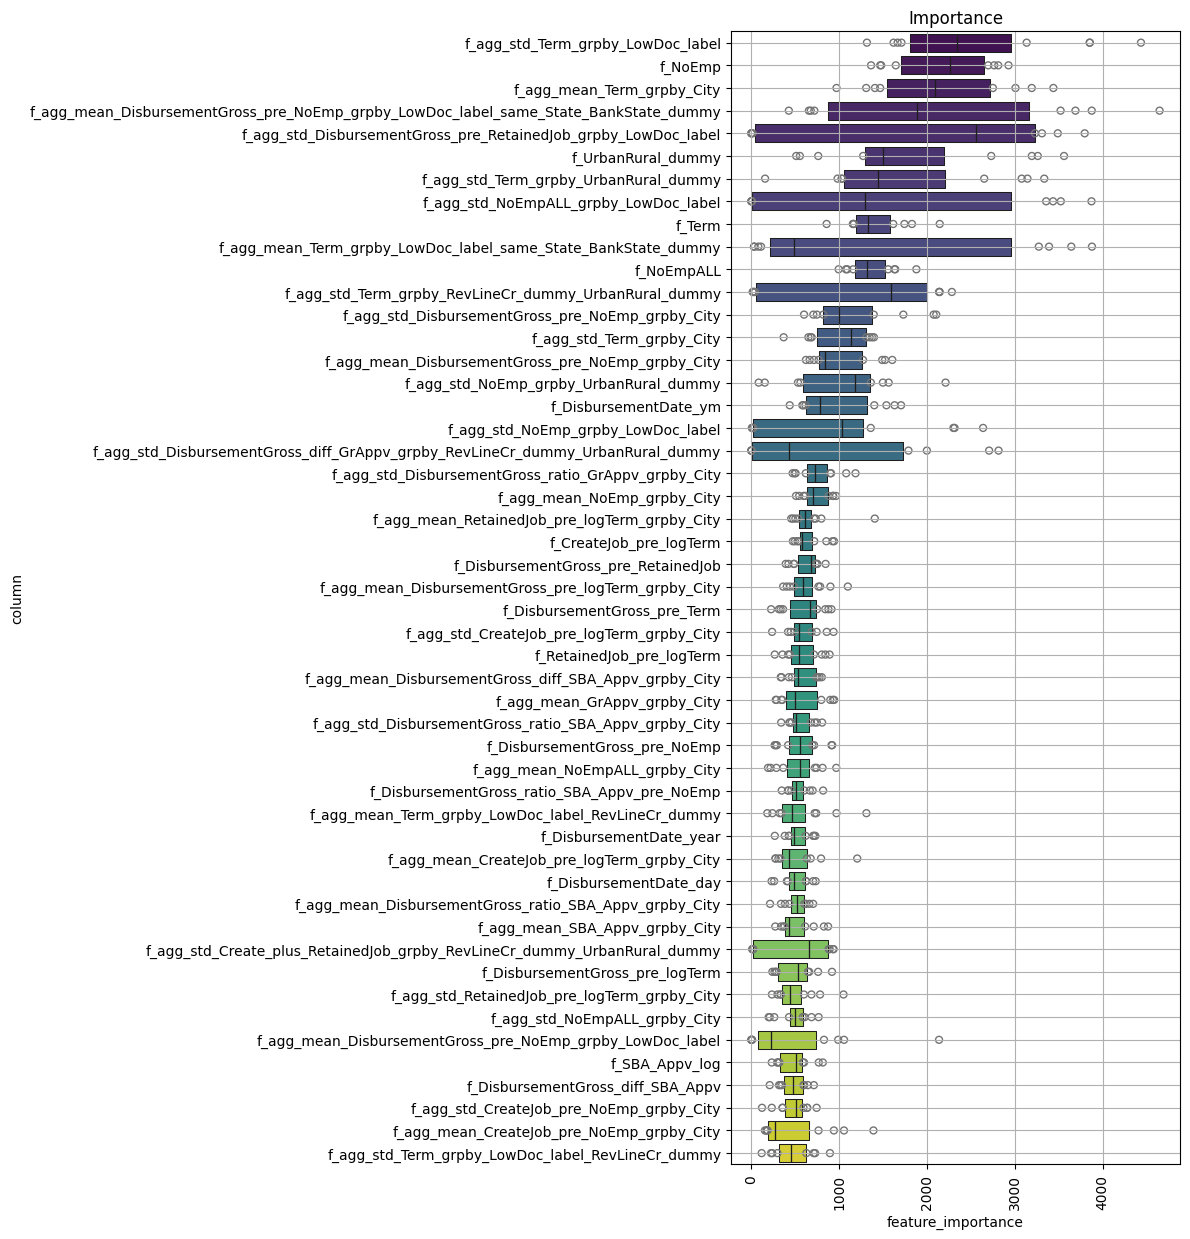

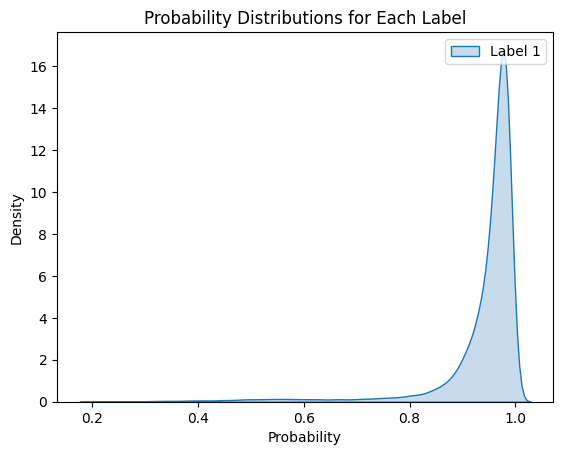

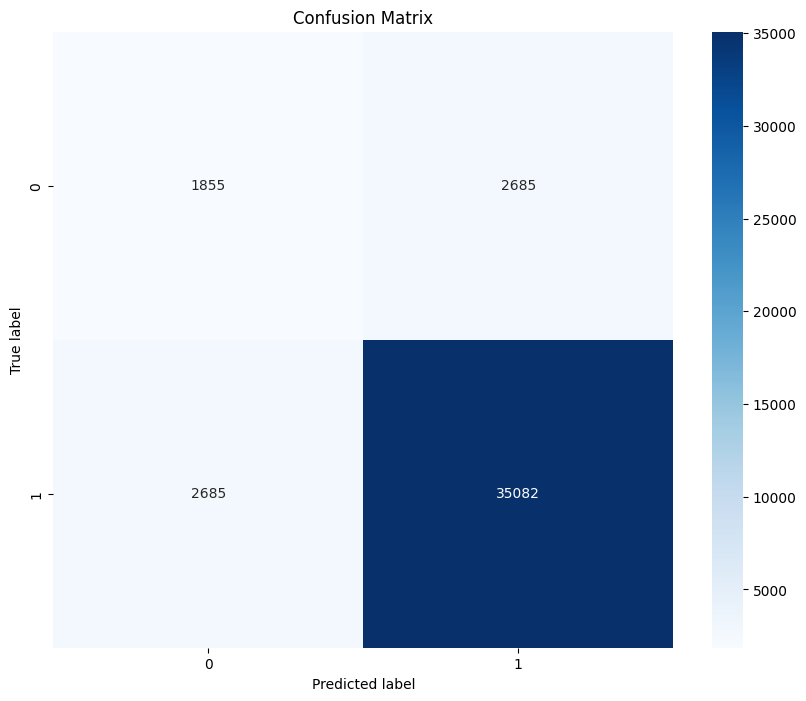

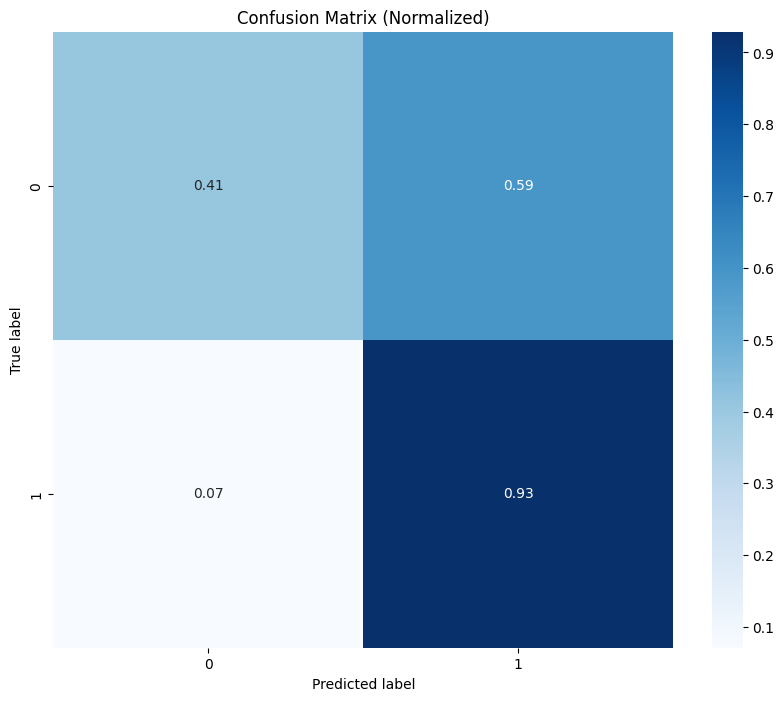

In [10]:
try:
    fig, importance_df = visualize_feature_importance(
        estimators=all_trained_estimators,
        feature_columns=feature_columns,
        top_n=50,
    )
    fig.savefig(OUTPUT_DIR / "feature_importance.png", dpi=300)
    importance_df.to_csv(OUTPUT_DIR / "feature_importance.csv", index=False)
except AttributeError as e:
    logger.warning(f"feature_importance plot failed: {e}")


fig = plot_label_distributions(
    proba_matrix=np.array(valid_result_df["pred"].tolist()).reshape(-1, 1)
)
fig.show()
fig.savefig(OUTPUT_DIR / "label_distributions.png", dpi=300)


fig = plot_confusion_matrix(y_true=valid_result_df["MIS_Status"], y_pred=val_pred_label)
fig.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)

fig = plot_confusion_matrix(
    y_true=valid_result_df["MIS_Status"], y_pred=val_pred_label, normalize=True
)
fig.savefig(OUTPUT_DIR / "confusion_matrix_normalized.png", dpi=300)

### Make submission


In [12]:
test_result_df = predict_cv_tabular_v1(
    df=test_feature_df,
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    test=True,
    predict_proba=CFG.model.get("predict_proba"),
    return_binary=CFG.model.get("return_binary"),
)

test_proba = np.array(test_result_df["pred"].tolist()).reshape(-1)
test_pred_df = (
    test_result_df[["uid"]].assign(pred=test_proba).groupby("uid").mean().reset_index()
)
test_pred_df["pred_label"] = (
    decode_v2(test_pred_df["pred"], pos_ratio=opt_result["pos_ratio"]) * 1
)

submission_df = (
    test_df[["uid"]]
    .merge(test_pred_df[["uid", "pred_label"]], on="uid", how="left")
    .astype({"pred_label": int})
)
submission_filepath = (
    Path(CFG.paths.output_dir)
    / f"submissions_{CFG.experiment_name}_{scores['all_opt']['score']:.3f}.csv"
)
submission_df.to_csv(submission_filepath, index=False, header=False)
joblib.dump(test_pred_df, OUTPUT_DIR / "test_result_df.pkl")

2024-02-10 18:09:16,576 - src.experiment.model.runner - INFO : fold0 predict : test=True
2024-02-10 18:09:16,927 - src.experiment.model.runner - INFO : fold1 predict : test=True
2024-02-10 18:09:17,151 - src.experiment.model.runner - INFO : fold2 predict : test=True
2024-02-10 18:09:17,379 - src.experiment.model.runner - INFO : fold3 predict : test=True
2024-02-10 18:09:17,597 - src.experiment.model.runner - INFO : fold4 predict : test=True
2024-02-10 18:09:17,891 - src.experiment.model.runner - INFO : fold5 predict : test=True
2024-02-10 18:09:18,153 - src.experiment.model.runner - INFO : fold6 predict : test=True
2024-02-10 18:09:18,428 - src.experiment.model.runner - INFO : fold7 predict : test=True
2024-02-10 18:09:18,644 - src.experiment.model.runner - INFO : fold8 predict : test=True
2024-02-10 18:09:18,836 - src.experiment.model.runner - INFO : fold9 predict : test=True
2024-02-10 18:09:19,081 - src.experiment.model.runner - INFO : fold10 predict : test=True
2024-02-10 18:09:19,

['/Users/masatotoba/Private/financial-data-challenge/resources/outputs/experiment=002-v02/test_result_df.pkl']